In [15]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

## Utilities

In [3]:
def plot_test_run_results(results, labels):
    colors = 'brgcmykw'
    
    ax1 = plt.subplot(1, 2, 1)
    for i, (r, l) in enumerate(zip(results, labels)):
        plt.plot(r.index, r['avg_reward'], colors[i % len(colors)], label=l)
    plt.xlabel('Step')
    plt.ylabel('Average Reward')
    ax1.legend()

    ax2 = plt.subplot(1, 2, 2)
    for i, (r, l) in enumerate(zip(results, labels)):
        plt.plot(r.index, r['percent_optimal'], colors[i % len(colors)], label=l)
    plt.xlabel('Step')
    plt.ylabel('% Optimal')
    ax2.yaxis.set_major_formatter(mp.ticker.PercentFormatter(1))
    ax2.legend()

    plt.show()

## 10-armed Bandit testbed

In [4]:
from abc import ABC, abstractmethod

class ValueDistribution(ABC):
    @abstractmethod
    def reward(self, action):
        pass
    
    @abstractmethod
    def optimal_action(self):
        pass
    
    @abstractmethod
    def reset(self):
        pass
    
class Learner(ABC):
    @abstractmethod
    def make_move(self):
        pass
    
    @abstractmethod
    def give_reward(self, selected_action, reward):
        pass
    
    @abstractmethod
    def reset(self):
        pass
    

In [5]:
def perform_run(learner, value_distribution, num_steps=1000):    
    reward = np.zeros(num_steps, dtype='float64')
    was_optimal = np.zeros(num_steps, dtype='float64')
    
    for i in range(num_steps):
        selected_action = learner.make_move()
        reward[i] = value_distribution.reward(selected_action)
        learner.give_reward(selected_action, reward[i])
        was_optimal[i] = 1 if selected_action == value_distribution.optimal_action() else 0
    
    return reward, was_optimal

def run_test(learner, value_distribution, num_runs=2000, steps_per_run=1000, enable_logging=False):    
    avg_reward = np.zeros(steps_per_run, dtype='float64')
    percent_optimal = np.zeros(steps_per_run, dtype='float64')

    for i in range(num_runs):
        learner.reset()
        value_distribution.reset()

        run_reward, run_was_optimal = perform_run(learner, value_distribution, steps_per_run)

        avg_reward += run_reward
        percent_optimal += run_was_optimal
        
        if enable_logging and (i + 1) % 100 == 0:
            print(f'Completed run {i+1} of {num_runs}.')

    avg_reward /= num_runs
    percent_optimal /= num_runs
    
    test_data = pd.DataFrame({'avg_reward': avg_reward, 'percent_optimal': percent_optimal})
    test_data.index.name = 'step'
    
    return test_data 

## Epsilon-Greedy Algorithm 

### Value Functions

In [6]:
class StationaryValue(ValueDistribution):
    def __init__(self, size=10):
        self.size = size
        
        self.value = np.random.randn(size)
        self.optimal_action_val = self.value.argmax()
    
    def reward(self, action):
        return self.value[action] + np.random.randn()
    
    def optimal_action(self):
        return self.optimal_action_val
    
    def reset(self):
        self.value = np.random.randn(self.size)
        self.optimal_action_val = self.value.argmax()

In [7]:
class NonStationaryValue(ValueDistribution):
    
    def __init__(self, size=10, drift_mean=0., drift_std=0.01):
        self.drift_mean = drift_mean
        self.drift_std = drift_std
        
        self.value = np.random.randn(size)
        self.original_value = np.copy(self.value)
    
    def reward(self, action):
        self.value += np.random.normal(self.drift_mean, self.drift_std, self.value.shape)
        return self.value[action] + np.random.randn()
    
    def optimal_action(self):
        return self.value.argmax()
    
    def reset(self):
        self.value = np.copy(self.original_value)

### Learners

In [8]:
class EpsGreedyLearner(Learner):
    def __init__(self, eps):
        if eps < 0 or eps > 1:
            raise Exception('Invalid eps probability')

        self.eps = eps
        
        self.countActionChosen = np.zeros(10)
        self.learnedQ = np.zeros(10)
        
    def make_move(self):
        p = np.random.uniform()
        
        action = 0

        if p <= self.eps:
            # Exploratory action
            action = np.random.randint(0, 10)
        else:
            # Greedy action
            action = self.learnedQ.argmax()
        
        self.countActionChosen[action] += 1
        return action
    
    def give_reward(self, action, reward):
        self.learnedQ[action] += (reward - self.learnedQ[action]) / self.countActionChosen[action]
        
    def reset(self):
        self.countActionChosen = np.zeros(10)
        self.rewardsWhenActionChosen = np.zeros(10)
        self.learnedQ = np.zeros(10)
        
    

In [9]:
class EpsGreedyConstantStepSizeLearner(Learner):
    def __init__(self, eps, alpha):
        if eps < 0 or eps > 1:
            raise Exception('Invalid eps probability')

        self.eps = eps
        self.alpha = alpha 
        
        self.learnedQ = np.zeros(10)
        
    def make_move(self):
        p = np.random.uniform()
        
        action = 0

        if p <= self.eps:
            # Exploratory action
            action = np.random.randint(0, 10)
        else:
            # Greedy action
            action = self.learnedQ.argmax()

        return action
    
    def give_reward(self, action, reward):
        self.learnedQ[action] += self.alpha * (reward - self.learnedQ[action])
        
    def reset(self):
        self.countActionChosen = np.zeros(10)
        self.rewardsWhenActionChosen = np.zeros(10)
        self.learnedQ = np.zeros(10)

In [10]:
class OptimisticEpsilonGreedyLearner(Learner):
    def __init__(self, eps, bias=0):
        self.bias = bias
        self.learner = EpsGreedyLearner(eps)
        self.learner.learnedQ.fill(bias)
        
    def make_move(self):
        return self.learner.make_move()
    
    def give_reward(self, selected_action, reward):
        self.learner.give_reward(selected_action, reward)
    
    def reset(self):
        self.learner.reset()
        self.learner.learnedQ.fill(self.bias)

### Stationary Process Test

In [11]:
data_eps_1 = run_test(EpsGreedyLearner(0.1), StationaryValue())
data_eps_01 = run_test(EpsGreedyLearner(0.01), StationaryValue())
data_greedy = run_test(EpsGreedyLearner(0.), StationaryValue())

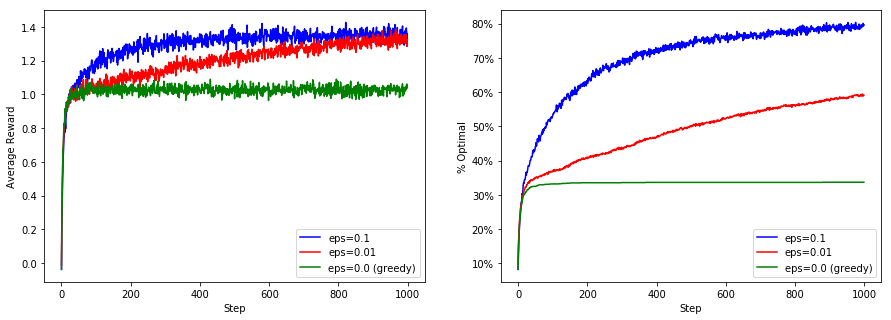

In [16]:
plot_test_run_results([data_eps_1, data_eps_01, data_greedy], ['eps=0.1', 'eps=0.01', 'eps=0.0 (greedy)'])

### Non-stationary Process Test

In [19]:
data_non_stationary_sample_average = run_test(
    EpsGreedyLearner(0.1), 
    NonStationaryValue(), 
    steps_per_run=10_000
)
data_non_stationary_constant_step = run_test(
    EpsGreedyConstantStepSizeLearner(eps=0.1, alpha=0.1), 
    NonStationaryValue(), 
    steps_per_run=10_000
)

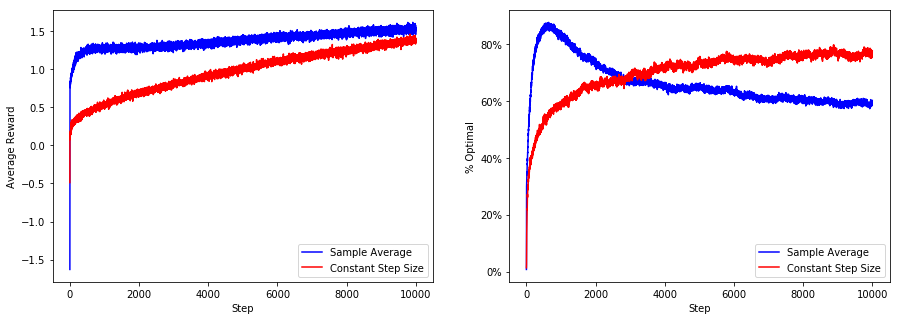

In [20]:
plot_test_run_results(
    [data_non_stationary_sample_average, data_non_stationary_constant_step], 
    ['Sample Average', 'Constant Step Size']
)

## Optimistic Initial Values

In [17]:
data_eps_realistic = run_test(EpsGreedyLearner(0.1), StationaryValue())
data_greedy_optimistic = run_test(OptimisticEpsilonGreedyLearner(0., bias=5), StationaryValue())

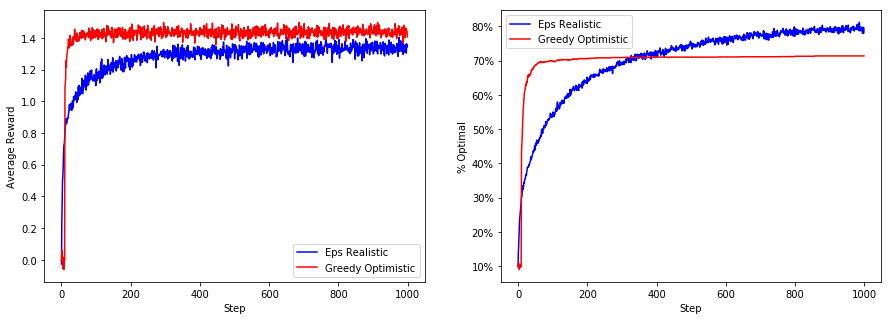

In [18]:
plot_test_run_results([data_eps_realistic, data_greedy_optimistic], ['Eps Realistic', 'Greedy Optimistic'])